Import Libraries

In [1]:
import pandas as pd
import numpy as np
from joblib import load
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn
import matplotlib
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
import skorch
from sklearn.metrics import accuracy_score,auc,classification_report,f1_score,precision_score,recall_score, precision_recall_curve

Import Pre-process Test Data which was obtained from pre-processig module

In [2]:
x_test = pd.read_csv('x_test.csv') #independent variables
y_test = pd.read_csv('y_test.csv') # target variables

In [3]:
x_test = np.array(x_test) #converted into array for fast computation
y_test = np.array(y_test).ravel()  

In [4]:
#Defiine input, output and dropout
input_layer = 9 # input is 9 as there are nine predictors
hidden_layers = [50,100] # experimented with different hidden layers list defines first hidden layer has 50 neurons and second has 100
output_layer = 2 #it is a binary classification, so two output layer
dropout = 0.5 

In [5]:
#Define Network, which will be required when model is loaded
class telescope_net(nn.Module):
    def __init__(self,
                 input_dim = input_layer,
                 hidden_dim = hidden_layers,
                 output_dim = output_layer,
                 dropout = dropout
                ):
        super(telescope_net, self).__init__() #instantiate nn.module
        self.fc1 = nn.Linear(input_layer, hidden_layers[0])
        self.dropout = nn.Dropout(dropout)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_layers[i], hidden_layers[i+1]) for i in range(len(hidden_layers)-1)])
       
        self.out = nn.Linear(hidden_dim[-1] ,output_layer)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim =-1) #dim -1 as my output is one dimensional
        #self.tanh = nn.Tanh()
      
        
    
    
    def forward(self, x): #x is input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
            x = self.dropout(x)
    
        x = self.softmax(self.out(x))
        
        
        return x

In [6]:
# from skorch.callbacks import Callback

# class EarlyStoppingAccuracyThreshold(Callback):
#     def __init__(self, accuracy_threshold):
#         super().__init__()
#         self.accuracy_threshold = accuracy_threshold

#     def on_epoch_end(self, net, dataset_train=None, dataset_valid=None, **kwargs): #https://skorch.readthedocs.io/en/stable/callbacks.html
#         if dataset_valid is not None:
#             accuracy = net.history[-1, 'valid_acc']
#             if accuracy > self.accuracy_threshold:
#                 print(f"Validation accuracy reached {accuracy*100}%, stopping training.")
#                 raise KeyboardInterrupt  # Interrupts the training loop

Import both best models:

In [7]:
svm_best_model= load('SVM_best_model')
mlp_best_model = load('MLP_best_model')


In [8]:
mlp_best_model.get_params_for_optimizer

<bound method NeuralNet.get_params_for_optimizer of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=telescope_net(
    (fc1): Linear(in_features=9, out_features=50, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=50, out_features=100, bias=True)
    )
    (out): Linear(in_features=100, out_features=2, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=-1)
  ),
)>

In [9]:
mlp_best_model.lr

0.003

# Predicting test data on  SVM model and producing Performance metrices

In [10]:

y_pred_svm= svm_best_model.predict(x_test) # perdicting output
y_proba_svm = svm_best_model.predict_proba(x_test)# Predict probabilities for 
#both class(gamma and hadron)

ROC curve and AUC of SVM

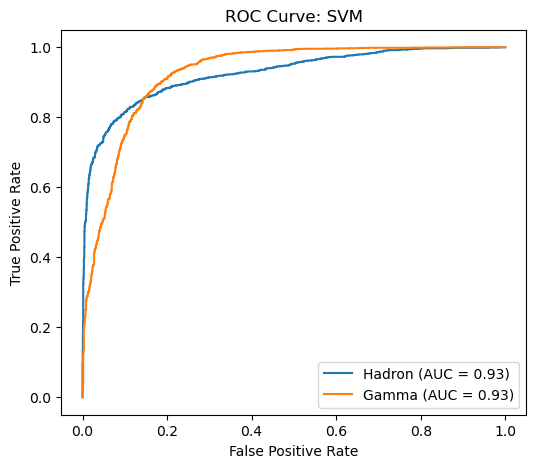

In [11]:
fpr_0, tpr_0, _ = roc_curve(y_test, y_proba_svm[:, 0], pos_label=0) # Compute FPR and TPR for creating ROC curve
fpr_1, tpr_1, _ = roc_curve(y_test, y_proba_svm[:, 1], pos_label=1)

roc_auc_0 = auc(fpr_0, tpr_0) # Calculate AUC values for both class
roc_auc_1 = auc(fpr_1, tpr_1)
#0 for Hadron and 1 for gamma

plt.figure(figsize=(6, 5)) #plot ROC curve for both class

# Plot ROC curve for Hadron (class 0)
plt.plot(fpr_0, tpr_0, label=f'Hadron (AUC = {roc_auc_0:.2f})')

# Plot ROC curve for Gamma (class 1)
plt.plot(fpr_1, tpr_1, label=f'Gamma (AUC = {roc_auc_1:.2f})')

# Set labels and legend
plt.xlabel('False Positive Rate') #set labels
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SVM')
plt.legend() #legends described in label above


plt.show()

Text(0.5, 1.0, 'Confusion matrix: SVM')

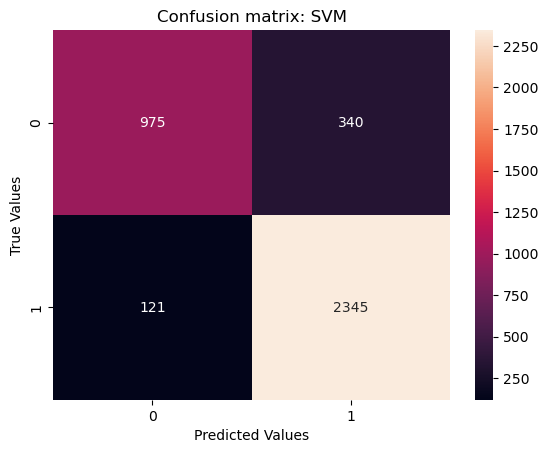

In [12]:
confusion_matrix_svm = confusion_matrix(y_test,y_pred_svm )  #create confusion matrix
sns.heatmap(confusion_matrix_svm, annot = True,fmt='d') # Plot confusion matrix using heatmap
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.title('Confusion matrix: SVM')

In [13]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_score_svm = f1_score(y_test, y_pred_svm)
precision_score_svm =  precision_score(y_test, y_pred_svm)
recall_score_svm = recall_score(y_test, y_pred_svm)

In [14]:
print(f'Performance Parameters of SVM (Accuracy: {accuracy_svm*100: .2f}%, F1_score: {f1_score_svm*100:.2f}%,precision_score: {precision_score_svm*100:.2f}%, recall_score: {recall_score_svm*100:.2f}%)'
     )

Performance Parameters of SVM (Accuracy:  87.81%, F1_score: 91.05%,precision_score: 87.34%, recall_score: 95.09%)


# Predicting test data on  MLP model and producing Performance metrices

In [15]:
#Changed datatype of features required for skorch to train the model
x_test_mlp = x_test.astype(np.float32)
y_test_mlp= y_test.astype(np.int64)

In [16]:
y_pred_mlp= mlp_best_model.predict(x_test_mlp) #predict the output
y_proba_mlp = mlp_best_model.predict_proba(x_test_mlp) #predict the output probabilities of the two class 

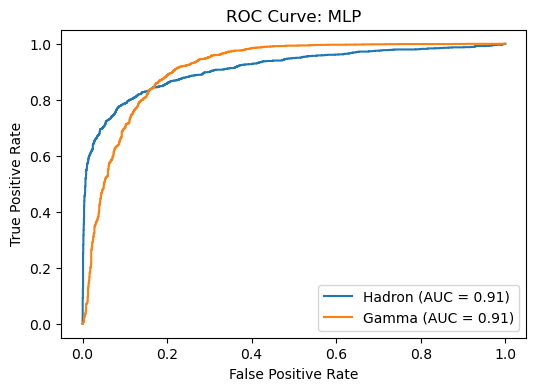

In [17]:
mlp_fpr_0, mlp_tpr_0, _ = roc_curve(y_test_mlp, y_proba_mlp[:, 0], pos_label=0)
mlp_fpr_1, mlp_tpr_1, _ = roc_curve(y_test_mlp, y_proba_mlp[:, 1], pos_label=1)
#0 for Hadron and 1 for gamma
mlp_roc_auc_0 = auc(mlp_fpr_0, mlp_tpr_0) # Calculate AUC values for both class
mlp_roc_auc_1 = auc(mlp_fpr_1, mlp_tpr_1)


plt.figure(figsize=(6, 4))   #plot ROC curve for both class

# Plot ROC curve for Hadron (class 0)
plt.plot(mlp_fpr_0, mlp_tpr_0, label=f'Hadron (AUC = {mlp_roc_auc_0:.2f})')
# Plot ROC curve for Gamma (class 1)
plt.plot(mlp_fpr_1, mlp_tpr_1, label=f'Gamma (AUC = {mlp_roc_auc_1:.2f})')

plt.xlabel('False Positive Rate') #set labels
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: MLP')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Confusion matrix: MLP')

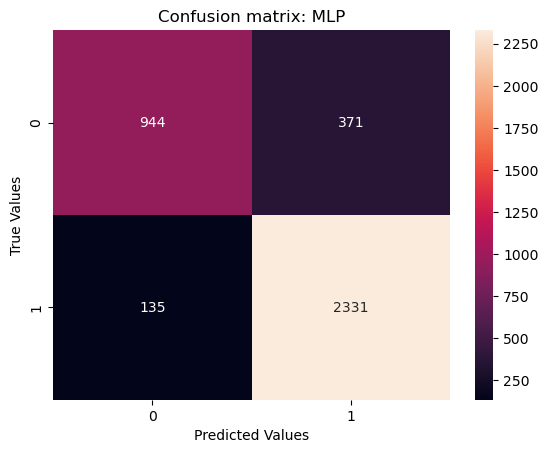

In [18]:
confusion_matrix_mlp = confusion_matrix(y_test_mlp,y_pred_mlp ) #create confusion matrix
sns.heatmap(confusion_matrix_mlp, annot = True,fmt='d') # Plot confusion matrix using heatmap
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.title('Confusion matrix: MLP')

In [19]:
accuracy_mlp = accuracy_score(y_test_mlp, y_pred_mlp)
f1_score_mlp = f1_score(y_test_mlp, y_pred_mlp)
precision_score_mlp =  precision_score(y_test_mlp, y_pred_mlp)
recall_score_mlp = recall_score(y_test_mlp, y_pred_mlp)

In [20]:
print(f'Performance Parameters of MLP (Accuracy: {accuracy_mlp*100:.2f}%, F1_score: {f1_score_mlp*100:.2f}%,precision_score: {precision_score_mlp*100:.2f}%, recall_score: {recall_score_mlp*100:.2f}%)'
     )

Performance Parameters of MLP (Accuracy: 86.62%, F1_score: 90.21%,precision_score: 86.27%, recall_score: 94.53%)


In [21]:
#Comparing Precision and recall curves for both the models

In [22]:
svm_precision, svm_recall, _ = precision_recall_curve(y_test, svm_best_model.predict_proba(x_test)[:, 1])
mlp_precision, mlp_recall, _ = precision_recall_curve(y_test_mlp, mlp_best_model.predict_proba(x_test_mlp)[:, 1])

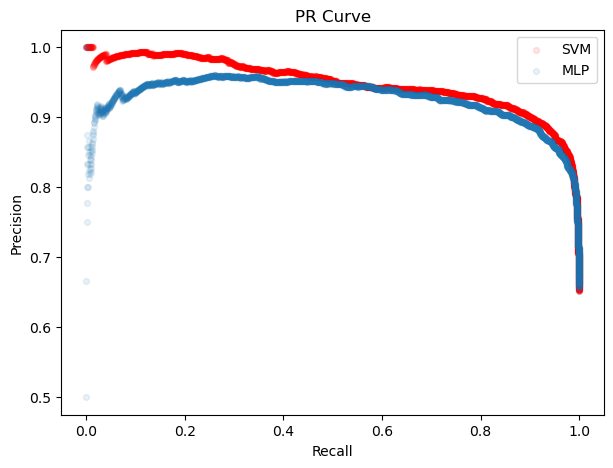

In [23]:
plt.figure(figsize=(7, 5))
plt.scatter(svm_recall, svm_precision, label='SVM', alpha =0.1, c= 'r', s=18 )
plt.scatter(mlp_recall, mlp_precision, label='MLP', alpha =0.1, s =18)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend()
plt.show()

In [24]:
#__________________________END TESTING_______________________________